In [1]:
import torch
import yaml
from models.unet import Unet
from models.vqvae import VQVAE
from linear_noise_scheduler import LinearNoiseScheduler

In [2]:
config_file = 'config/celebhq.yaml'

with open(config_file, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

diffusion_config = config['diffusion_params']
dataset_config = config['dataset_params']
diffusion_model_config = config['ldm_params']
autoencoder_model_config = config['autoencoder_params']
train_config = config['train_params']


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Unet(im_channels=autoencoder_model_config['z_channels'],
             model_config=diffusion_model_config).to(device)

vae = VQVAE(im_channels=dataset_config['im_channels'],
            model_config=autoencoder_model_config).to(device)

model.eval()
vae.eval()

VQVAE(
  (enconder_conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_layers): ModuleList(
    (0): DownBlock(
      (resnet_conv_first): ModuleList(
        (0): Sequential(
          (0): GroupNorm(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Sequential(
          (0): GroupNorm(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (resnet_conv_second): ModuleList(
        (0-1): 2 x Sequential(
          (0): GroupNorm(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (residual_input_conv): ModuleList(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(128, 128, kernel_size=(1, 1), stride

In [4]:
checkpoint_ddpmfile = 'celebhq/ddpm_ckpt/ddpm_ckpt_325000.pth'
checkpoint_ddpm = torch.load(checkpoint_ddpmfile)

model.load_state_dict(checkpoint_ddpm['model'])

checkpoint_vqvaefile = 'celebhq/vqvae_ckpt/autoenconder_ckpt_149999.pth'
checkpoint_vqvae = torch.load(checkpoint_vqvaefile)

vae.load_state_dict(checkpoint_vqvae['model'])

/tmp/ipykernel_555916/1211305192.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_ddpm = torch.load(checkpoint_ddpmfile)
/tmp/ipykernel_555916/1211305192.py:7:

<All keys matched successfully>

In [5]:
noise_scheduler = LinearNoiseScheduler(
    num_timesteps=diffusion_config['num_timesteps'],
    beta_start=diffusion_config['beta_start'],
    beta_end=diffusion_config['beta_end']
)

In [ ]:
from tqdm import tqdm

def sample(model, scheduler, im_size, down_sample, device, num_samples, z_channels, num_timesteps, vae):
    im_size = im_size // down_sample

    xt = torch.randn((num_samples,
                      z_channels,
                      im_size, im_size)).to(device)
    
    for i in tqdm(reversed(range(num_timesteps))):
        # get prediction of noise
        noise_pred = model(xt, torch.as_tensor(i).unsqueeze(0).to(device))

        # use scheduler to get x0 and xt-1
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))


        if i == 0:
            # decode only final image to save
            imgs = vae.decode(xt)
            imgs = torch.clamp(imgs, -1., 1.).detach().cpu()
            imgs = (imgs + 1) / 2 # convert to [0, 1]
            return imgs


In [35]:
down_sample= 2 ** sum(autoencoder_model_config['down_sample'])

with torch.no_grad():
    imgs = sample(
        model, noise_scheduler, im_size=dataset_config['im_size'],
        down_sample=down_sample, device=device, num_samples=8,
        z_channels=autoencoder_model_config['z_channels'],
        num_timesteps=diffusion_config['num_timesteps'], vae=vae,
    )

999it [01:27, 11.44it/s]


In [36]:
imgs = imgs.permute(0, 3, 2, 1).numpy()

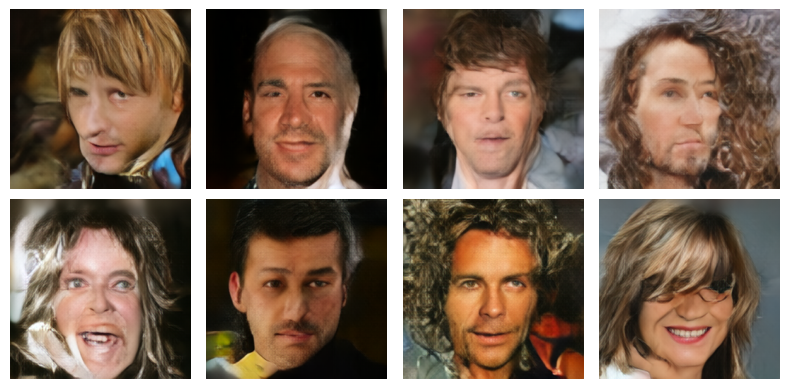

In [43]:
import matplotlib.pyplot as plt
import numpy as np

rows, cols = 2, 4
fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
axes = axes.ravel()  # Flatten axes for easy indexing

for i in range(rows * cols):
    if i < len(imgs):
        axes[i].imshow(np.rot90(imgs[i], axes=(1,0)), cmap='gray' if imgs[i].ndim == 2 else None)
        axes[i].axis('off')  # Hide axes for each subplot
    else:
        axes[i].remove()  # Remove empty subplots if batch is smaller than rows*cols

plt.tight_layout()
plt.show()